In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cmdstanpy import CmdStanModel
from baynes.plotter import *
plt.style.use('ggplot')

# Example 1: fit of a poissonian process
### Generate the data

- mean of data:  8.004
- sd of data:  2.7331271466947893


<AxesSubplot: ylabel='Count'>

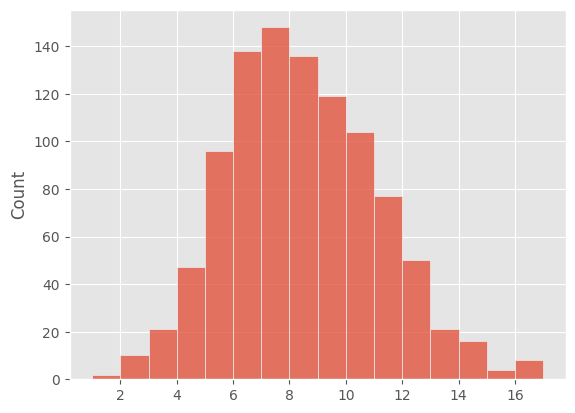

In [3]:
lambda_true = 8
events = np.random.poisson(lambda_true, 1000)

data_mean = np.mean(events)
data_sd = np.std(events)
print('- mean of data: ', data_mean)
print('- sd of data: ', data_sd)
sns.histplot(events, bins=np.arange(min(events), max(events)))

### Compile and print the STAN model


In [4]:
stan_file = 'examples/poissonian/pois.stan'
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={'STAN_THREADS': True, 'jN': 4})

In [5]:
print(model.code())

data {
  int<lower=0> N;
  array[N] int y;
  real mu;
  real sigma;
  int<lower=0, upper=1> prior;
}

transformed data {
  real<lower = 0> mean_y = mean(to_vector(y));
  real<lower = 0> sd_y = sd(to_vector(y));
}

parameters {
  real<lower=0> lambda;
}

model {
  lambda ~ lognormal(mu, sigma);
  y ~ poisson(lambda);
}

generated quantities {
  array[N] int<lower = 0> y_rep;
  if (prior == 0)
    y_rep = poisson_rng(rep_array(lambda, N));
  else
    y_rep = poisson_rng(rep_array(lognormal_rng(mu, sigma), N));
  real<lower = 0> mean_y_rep = mean(to_vector(y_rep));
  real<lower = 0> sd_y_rep = sd(to_vector(y_rep));
}



### Assemble the data
The model fits a poissonian with a lognormal prior for the only parameter $\lambda$. The variables 'mu' and 'sigma' are the parameters of the lognormal, while 'prior' selects whether to generate simulated data only from the prior (1) or from the fit (0)

In [6]:
data = {'N': len(events), 'y': events, 'mu': 2, 'sigma': 0.3, 'prior': 1}

### Prior predictive check
Run the model without warmup and with fixed parameters

In [7]:
fit_prior = model.sample(data,
                         chains=4,
                         iter_warmup=0,
                         iter_sampling=1000,
                         save_warmup=False,
                         show_progress=False,
                         fixed_param=True)

21:25:35 - cmdstanpy - INFO - CmdStan start processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [2] start processing
21:25:35 - cmdstanpy - INFO - Chain [3] start processing
21:25:35 - cmdstanpy - INFO - Chain [4] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [4] done processing
21:25:36 - cmdstanpy - INFO - Chain [2] done processing
21:25:37 - cmdstanpy - INFO - Chain [3] done processing


Initialize a FitPlotter object adding the fit and its title (optional), then plot a predictive check. By default, the 5-95% interval of the simulated data is drawn. If the data is unbinned, as in this case, pass the number of bins that will be used in the plot as an additional argument. 

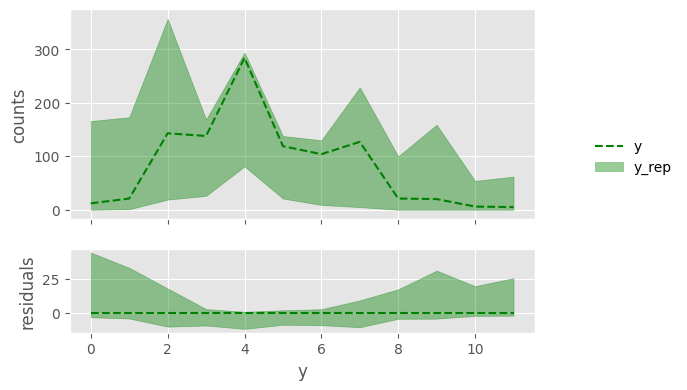

In [8]:
plotter = FitPlotter(fit_prior, fit_title='prior_fit')
plotter.predictive_check('y_rep', 
                         data=data, 
                         data_key='y', 
                         n_bins=12)

It is also possible to draw part of the simulated data as separate lines

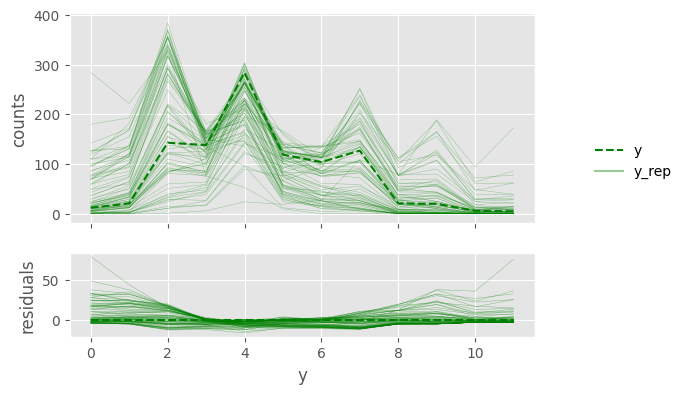

In [9]:
plotter.predictive_check('y_rep', 
                         data=data, 
                         data_key='y', 
                         lines=True,
                         n_bins=12)

### Fit the model
Allow to generate quantities depending on the fit parameter, then sample specifying the warmup iterations. Use $diagnose()$ to check the convergence of the fit.

In [10]:
data['prior'] = 0
fit = model.sample(data,
                   chains=4,
                   iter_warmup=100,
                   iter_sampling=1000,
                   save_warmup=True,
                   show_progress=True,
                   fixed_param=False)
print(fit.diagnose())

21:25:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:25:52 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /tmp/tmp4h0djyaf/poisbevia7ig/pois-20230412212550_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4h0djyaf/poisbevia7ig/pois-20230412212550_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4h0djyaf/poisbevia7ig/pois-20230412212550_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp4h0djyaf/poisbevia7ig/pois-20230412212550_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Add the new fit to the FitPlotter and inspect the convergence of the only parameter. By default, new fits are added to an internal dictionary and new graphs are generated from the last added fit. All the parameters are plotted if None is passed as the first argument of the plotting function.

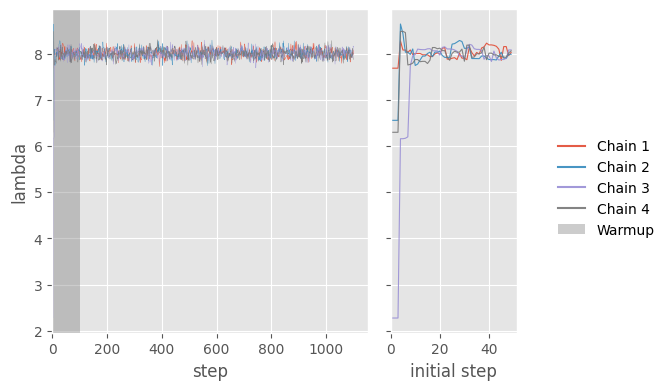

In [11]:
plotter.add_fit(fit, fit_title='poisson_fit')
plotter.convergence_plot()

Plot the posterior predictive check

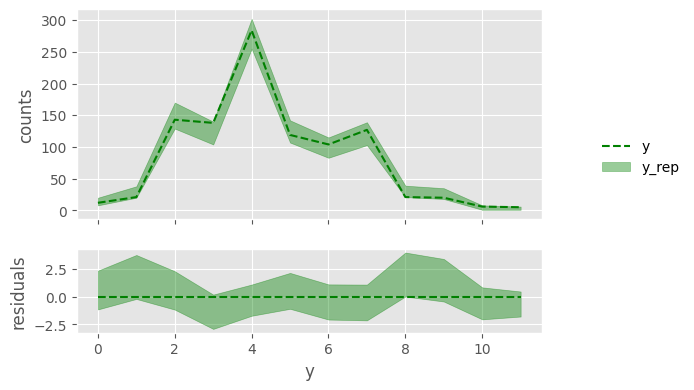

In [12]:
plotter.predictive_check('y_rep', 
                         data=data, 
                         data_key='y', 
                         n_bins=12)

Print the results for the parameter $lambda$ and plot its posterior distribution.

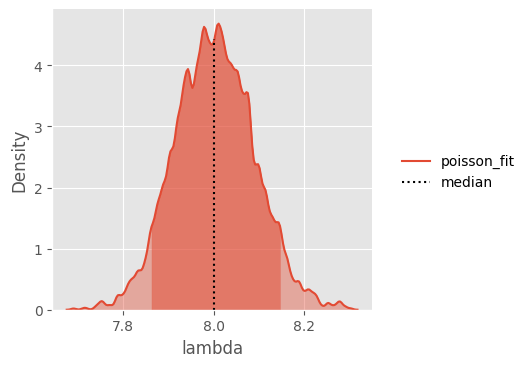

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lambda,8.00243,0.002253,0.08756,7.86201,8.00187,8.14683,1509.85,240.998,1.0022


In [13]:
plotter.kde_plot()
fit.summary().loc[['lambda']]

Most of the plots support multiple parameters and fit combinations. For example, we can compare the prior and posterior distributions for the simulated data's mean and standard deviation. This can also be done with wrappers of Seaborn's functions $displot$ and $catplot$, allowing for many possibilities

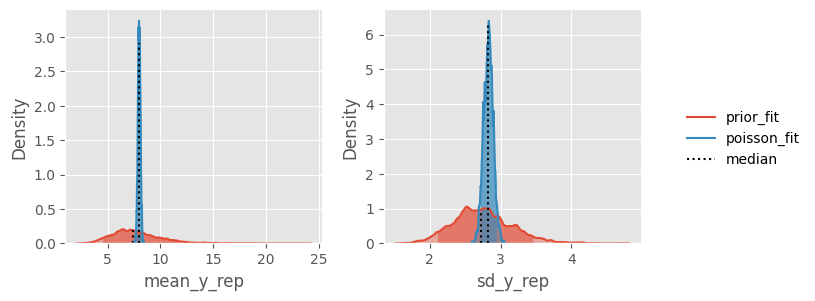

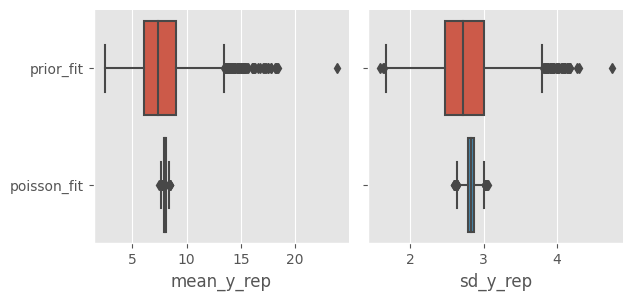

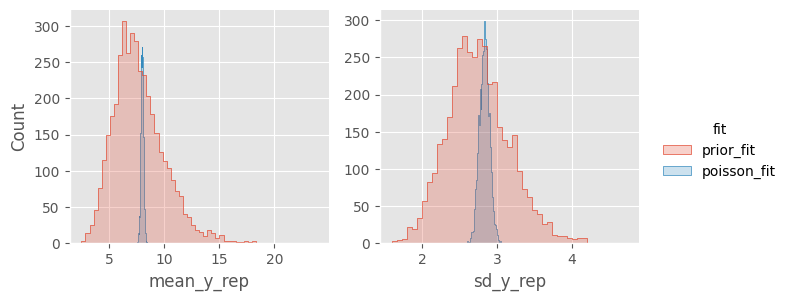

In [14]:
variables = ['mean_y_rep', 'sd_y_rep']
plotter.fig_scale = 5
plotter.kde_plot(variables, fit_titles='all')
plotter.cat_plot(variables, fit_titles='all', kind='box')
plotter.dis_plot(variables, fit_titles='all', kind='hist', common_bins=False, element="step")

It is also possible to add vertical and horizontal lines to the last created figure. In this case we can see that not only the fit has converged to the true value, but also that the simulated data mean and standard deviation converge to that of the real data. This means that the model can qualitatively describe various properties of the data and is a good indicator of its usefulness.

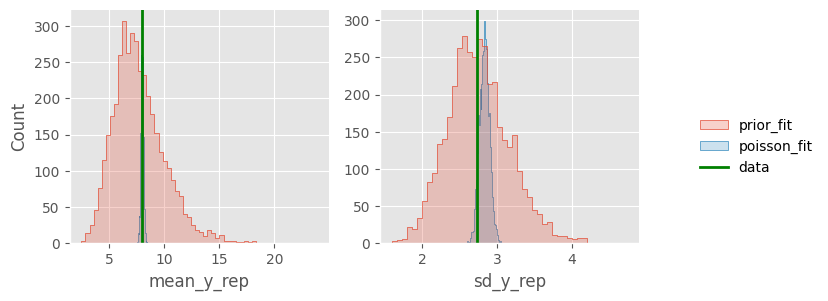

In [15]:
plotter.add_lines(x_coords=[data_mean, data_sd], 
                  label='data', 
                  color='green',
                  lw=2) 

## Prior influence
We can assess the robustness of the fit to different choiches of priors

In [16]:
data = {'N': len(events), 'y': events, 'mu': 2, 'sigma': 0.3, 'prior': 0}

plot = FitPlotter()
for mu in [1, 2, 4, 7, 10, 14, 18, 25]: 
    data['mu'] = mu
    fit = model.sample(data,
                       chains=4,
                       iter_warmup=100,
                       iter_sampling=500,
                       save_warmup=False,
                       show_progress=False)
    plot.add_fit(fit, fit_title='mu=' + str(mu))

21:27:05 - cmdstanpy - INFO - CmdStan start processing
21:27:05 - cmdstanpy - INFO - CmdStan start processing
21:27:06 - cmdstanpy - INFO - CmdStan done processing
21:27:06 - cmdstanpy - INFO - CmdStan start processing
21:27:06 - cmdstanpy - INFO - CmdStan start processing
21:27:07 - cmdstanpy - INFO - CmdStan done processing
21:27:07 - cmdstanpy - INFO - CmdStan start processing
21:27:07 - cmdstanpy - INFO - CmdStan start processing
21:27:08 - cmdstanpy - INFO - CmdStan done processing
21:27:09 - cmdstanpy - INFO - CmdStan start processing
21:27:09 - cmdstanpy - INFO - CmdStan start processing
21:27:09 - cmdstanpy - INFO - CmdStan done processing
21:27:10 - cmdstanpy - INFO - CmdStan start processing
21:27:10 - cmdstanpy - INFO - CmdStan start processing
21:27:10 - cmdstanpy - INFO - CmdStan done processing
21:27:11 - cmdstanpy - INFO - CmdStan start processing
21:27:11 - cmdstanpy - INFO - CmdStan start processing
21:27:11 - cmdstanpy - INFO - CmdStan done processing
21:27:12 - cmdst

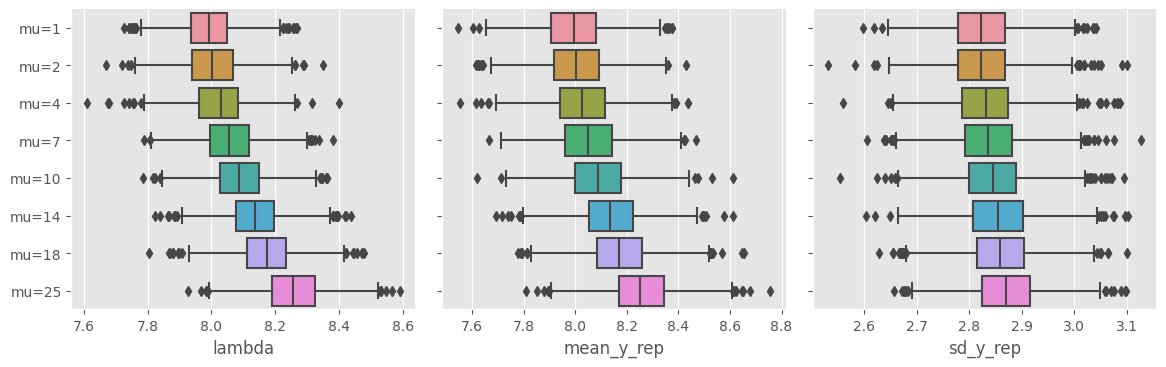

In [17]:
variables = ['lambda', 'mean_y_rep', 'sd_y_rep']
plot.cat_plot(variables, fit_titles='all', kind='box')

The fit is very robust, considering that for $mu=10$ the prior is completely off

<AxesSubplot: ylabel='Count'>

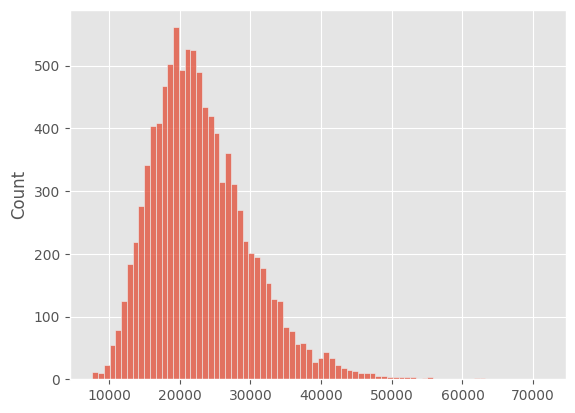

In [18]:
sns.histplot(np.random.lognormal(10, 0.3, 10000))

Will a smaller dataset, wrong priors will bias the result much more

In [19]:
plot_reduced = FitPlotter()

data['N'] = 100
data['y'] = events[:100]
for mu in [1, 2, 4, 7, 10, 14, 18, 25]: 
    data['mu'] = mu
    fit = model.sample(data,
                       chains=4,
                       iter_warmup=100,
                       iter_sampling=500,
                       save_warmup=False,
                       show_progress=False)
    plot_reduced.add_fit(fit, fit_title='mu=' + str(mu))

21:27:23 - cmdstanpy - INFO - CmdStan start processing
21:27:23 - cmdstanpy - INFO - CmdStan start processing
21:27:23 - cmdstanpy - INFO - CmdStan done processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan done processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan done processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan start processing
21:27:24 - cmdstanpy - INFO - CmdStan done processing
21:27:25 - cmdstanpy - INFO - CmdStan start processing
21:27:25 - cmdstanpy - INFO - CmdStan start processing
21:27:25 - cmdstanpy - INFO - CmdStan done processing
21:27:25 - cmdstanpy - INFO - CmdStan start processing
21:27:25 - cmdstanpy - INFO - CmdStan start processing
21:27:25 - cmdstanpy - INFO - CmdStan done processing
21:27:25 - cmdst

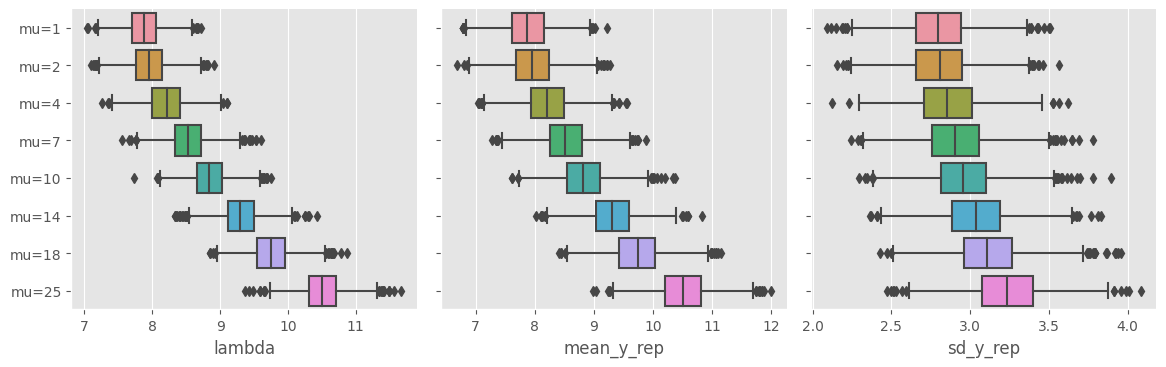

In [20]:
plot_reduced.cat_plot(['lambda', 'mean_y_rep', 'sd_y_rep'], fit_titles='all', kind='box')

Finally, it is possible to (manually as of now) merge the data from different FitPlotter instances and obtain nested comparisons

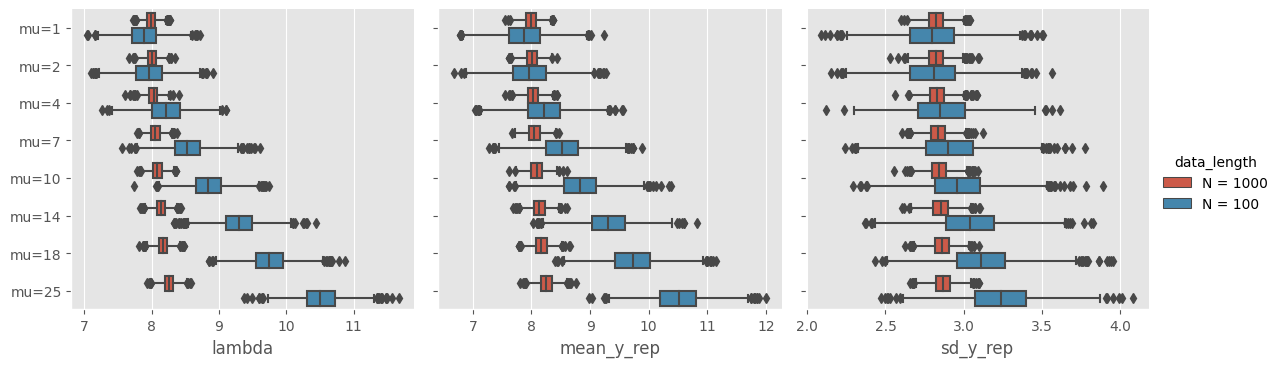

In [21]:
df1 = plot.draws_df(fit_titles='all', parameters=variables)
df2 = plot_reduced.draws_df(fit_titles='all', parameters=variables)
df1['data_length'] = 'N = 1000'
df2['data_length'] = 'N = 100'
draws_df = pd.concat([df1, df2])
plot.cat_plot(variables, df=draws_df, id_vars=['fit', 'data_length'], hue='data_length')

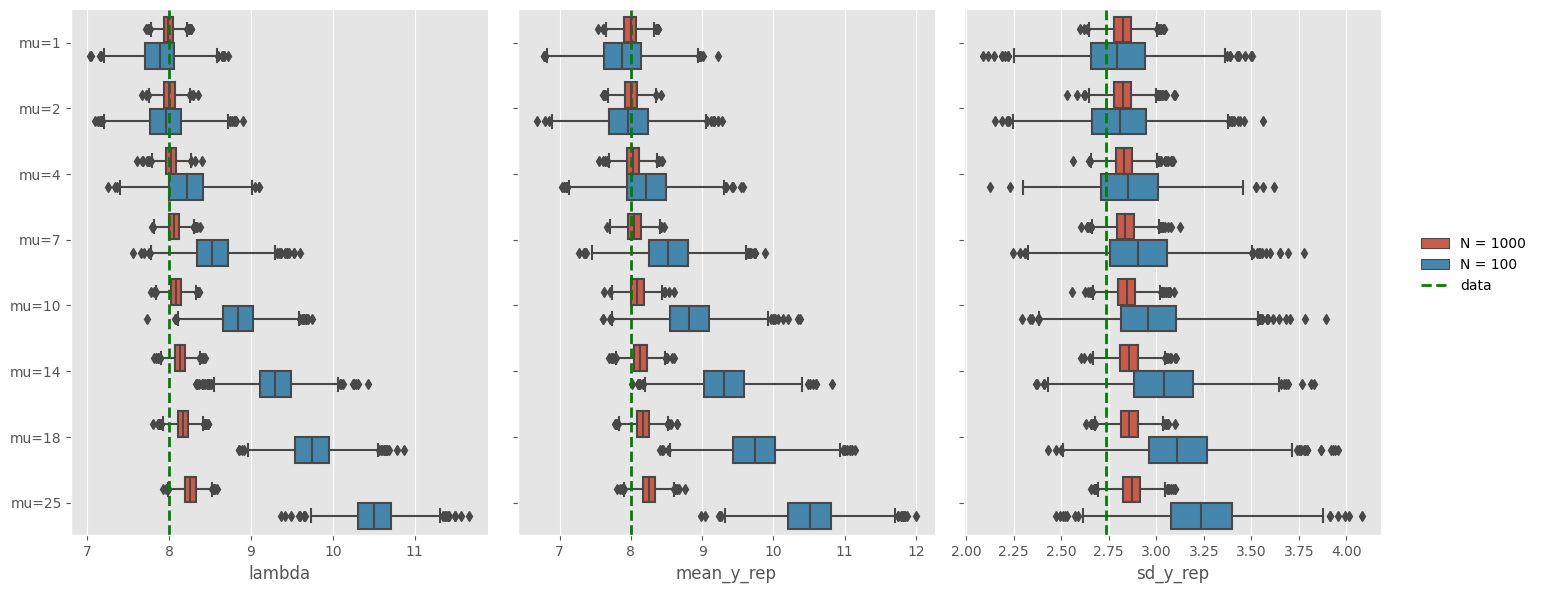

In [22]:
f = plot.add_lines(x_coords=[lambda_true, data_mean, data_sd],  
                   color='green', 
                   ls='--', 
                   lw=2, 
                   label='data', 
                   bbox_to_anchor=(1,0.6)) 
plot.resize(16, 7)
